In [ ]:
!pip install torch
!pip install torchvision
!pip install tqdm
!pip install seaborn
!pip install sklearn
!pip install transformers

In [1]:
import os
import glob
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from torch.utils.data import (
    Dataset,
    DataLoader,
)

from torchvision.datasets import ImageFolder
from torchvision.transforms import (
    RandomResizedCrop,
    RandomHorizontalFlip,
    RandomVerticalFlip,
    ColorJitter,
    RandomGrayscale,
    RandomApply,
    Compose,
    GaussianBlur,
    ToTensor,
    Normalize,
    CenterCrop,
    Resize
)
import torchvision.models as models
from torch.optim.lr_scheduler import StepLR

import numpy as np
# from skimage import io
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from PIL import Image
import seaborn as sns
import pandas as pd
import ast
import cv2

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
from sklearn.metrics import roc_curve
from sklearn.decomposition import PCA

In [2]:
torch.cuda.set_device("cuda:0")

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'DEVICE: {DEVICE}')

DEVICE: cuda


In [4]:
run_name = 'simclr_rad-dino_pos-pairs_neg-pairs_aug-pairs_100_epoch'

In [5]:
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # batch_size = 64
    # learning_rate = 3e-4
    # num_epochs = 100
    # patience = 5
    # temperature = 0.1
    # pair_loss_weight = 1.0
    # contrast_loss_weight = 0.7
    # max_norm = 1.0
    # best_model_path = "best_model.pth"
    # scheduler_step_size = 10
    # scheduler_gamma = 0.1

In [6]:
class Config:
    def __init__(self):
        self.learning_rate = 0.001
        self.num_epochs = 100
        self.batch_size = 40  # Adjust as needed
        self.patience = 30
        self.dropout_p = 0.3
        self.image_shape = [256, 256]
        self.kernel_size = [21, 21]  # For the transforms, 10% of image size
        self.embedding_size = 128
        self.scheduler_step_size = 70
        self.scheduler_gamma = 0.1
        self.weight_decay = 1e-5
        self.max_norm = 1.0  # Gradient clipping
        self.temperature = 2.0
        self.pair_loss_weight = 1.0
        self.contrast_loss_weight = 0.7
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.base_path = f"/home/saahmed/scratch/projects/Image-segmentation/retrieval/checkpoints/{run_name}"
        os.makedirs(self.base_path, exist_ok=True)
        self.best_model_path = os.path.join(self.base_path, "best_model.pth")
        self.last_model_path = os.path.join(self.base_path, "last_model.pth")
        self.learning_plot_path = os.path.join(self.base_path, "learning_curves.png")

config = Config()

In [7]:
from enum import Enum
from torchvision import transforms
from PIL import Image, ImageEnhance, ImageOps
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import random

def convert_to_rgb(img):
    """
    Convert an image to RGB.

    Args:
        img (PIL.Image.Image): The input image.

    Returns:
        PIL.Image.Image: The same image in RGB.
    """
    return img.convert("RGB")

def convert_to_ycbcr(img):
    """
    Convert an image to YCbCr.

    Args:
        img (PIL.Image.Image): The input image.

    Returns:
        PIL.Image.Image: The same image in YCbCr.
    """
    return img.convert("YCbCr")



class RandomAdjustSharpness:
    def __init__(self, factor_low, factor_high):
        """
        Adjust image sharpness with factor randomly chosen between factor_low
        and factor_high. A factor of 0 gives blurred image and a factor of 1
        gives the original image.

        Args:
            factor_low (float): The lower bound of the sharpness factor.
            factor_high (float): The upper bound of the sharpness factor.
        """
        self.factor_low = factor_low
        self.factor_high = factor_high

    def __call__(self, img):
        factor = np.random.uniform(self.factor_low, self.factor_high)
        return ImageEnhance.Sharpness(img).enhance(factor)


# class RandomEqualize:
#     def __init__(self, p=0.5):
#         """
#         Equalise the image histogram. Can be applied to colour images by
#         converting to YCbCr format first (which separates raw intensity from
#         other channels), applying equalisation, then converting back to RGB.

#         Args:
#             p (float, optional): The probability of applying equalization.
#                 Defaults to 0.5.
#         """
#         self.p = p

#     def __call__(self, img):
#         if np.random.rand() < self.p:
#             img = convert_to_ycbcr(img)
#             y, cb, cr = img.split()
#             y_eq = ImageOps.equalize(y)
#             img = Image.merge("YCbCr", (y_eq, cb, cr))
#             img = convert_to_rgb(img)
#             return img
#         return img



class AddGaussianNoise(object):
    def __init__(self, mean=0.0, std=0.05):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + f'(mean={self.mean}, std={self.std})'


class AugmentationSequenceType(Enum):
    """
    Augmentation sequence for SimCLR pretraining
    """
    NATURAL = "natural"
    SIMPLE = "simple"
    NOVEL = "novel"
    NOVEL_GREYSCALE = "greyscale"
    temp = "temp"
    normal = 'normal'

augmentation_sequence_map = {

    
    AugmentationSequenceType.temp.value: 
        transforms.Compose([
            transforms.Resize((config.image_shape[0], config.image_shape[1])),
            transforms.Lambda(convert_to_rgb),
           
            # Rotate the image by a random angle within ±15°
            transforms.RandomRotation(degrees=10),
            
            # Randomly flip horizontally and vertically (if clinically acceptable)
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            
            transforms.Lambda(lambda img: transforms.functional.adjust_contrast(img, contrast_factor=random.uniform(1, 1.3))),
            # Convert image to a tensor (results in a 1-channel tensor for grayscale)
            transforms.ToTensor(),
    
            ]),

    AugmentationSequenceType.normal.value: 
            transforms.Compose([
                transforms.Resize((config.image_shape[0], config.image_shape[1])),
                transforms.Lambda(convert_to_rgb),
               
                transforms.ToTensor(),
        
                ]),
}


In [8]:
class ContrastiveLearningViewGenerator(object):
    """Take an image (or a batch of images) and return
    n_views (2 by default) which are the result of applying
    the base_transform. That transform has random transformations
    which alter the images differently."""

    def __init__(self, base_transform,normal_transform, n_views=2):
        self.base_transform = base_transform
        self.normal_transform = normal_transform
        self.n_views = n_views

    def __call__(self, x):
        if random.random() < 0.5:
            views = [self.base_transform(x) for _ in range(self.n_views)]
        else:
            views = [self.normal_transform(x), self.base_transform(x)]
        return views

In [9]:
class CombinedContrastiveDataset(Dataset):
    def __init__(self, list_images, positive_pairs, negative_pairs, base_transform, normal_transform):
        self.positive_pairs = positive_pairs
        self.negative_pairs = negative_pairs
        self.list_images = list_images
        self.base_transform = base_transform
        self.normal_transform = normal_transform
        self.view_generator = ContrastiveLearningViewGenerator(base_transform, normal_transform, n_views=2)
        
        # Store pairs with labels (1 for positive, 0 for negative)
        self.paired_samples = [
            (img1, img2, 1) for img1, img2 in self.positive_pairs
        ] + [
            (img1, img2, 0) for img1, img2 in self.negative_pairs
        ]

    def __len__(self):
        return len(self.paired_samples) + len(self.list_images)

    def __getitem__(self, idx):
        if idx < len(self.paired_samples):
            # Handle positive/negative pairs
            img1_path, img2_path, label = self.paired_samples[idx]
            img1 = self.normal_transform(Image.open(img1_path))
            img2 = self.normal_transform(Image.open(img2_path))
            return img1, img2, torch.tensor(label, dtype=torch.float)
        else:
            # Handle single images (SimCLR-style augmented views)
            img_path = self.list_images[idx - len(self.paired_samples)]
            img = Image.open(img_path)
            views = self.view_generator(img)
            return views[0], views[1], torch.tensor(-1.0)  # Dummy label for single images

In [10]:
images_list_train = []
for i in ['es','ed']:
  path = f'/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/{i}/images/'
  images = [path+i for i in os.listdir(path)]
  images_list_train += images

In [11]:
def train_val_test_split(list_filenames, train_size=0.7):

    list_filenames_train, list_filenames_val = train_test_split(list_filenames,
                                                                      train_size=train_size,
                                                                      shuffle=True,
                                                                      random_state=42)


    return list_filenames_train, list_filenames_val

list_images = images_list_train
list_images_train, list_images_val = train_val_test_split(list_images)

In [12]:
print("Total number of images: ", len(list_images))
print("Images in train split: ", len(list_images_train))
print("Images in validation split: ", len(list_images_val))

Total number of images:  1902
Images in train split:  1331
Images in validation split:  571


In [13]:
import re
from collections import defaultdict

def create_positive_pairs(images): 
    file_list = sorted(images)
    pattern = re.compile(r'patient(\d+)_frame(\d+)_slice_(\d+)\.png')
    
    # Group images by (patient, frame)
    groups = defaultdict(list)
    for path in file_list:
        # Get just the file name
        filename = os.path.basename(path)
        match = pattern.search(filename)
        if match:
            patient = match.group(1)      # e.g. "001"
            frame = match.group(2)        # e.g. "01" or "12"
            slice_num = int(match.group(3))
            key = (patient, frame)
            groups[key].append((slice_num, path))
        else:
            print(f"File {path} does not match the expected pattern.")
    
    # Create positive pairs by pairing adjacent slices within each (patient, frame) group.
    positive_pairs = []
    for key, slices in groups.items():
        # Sort images by slice number within the group
        slices.sort(key=lambda x: x[0])
        # Create a pair for each adjacent slice only if more than one image exists
        for i in range(len(slices) - 1):
            img1 = slices[i][1]
            img2 = slices[i + 1][1]
            if (eval(img1.split('_')[-1].replace('.png','')) + 1) == eval(img2.split('_')[-1].replace('.png','')):
                positive_pairs.append((img1, img2))
        # else:
            # print(img1,'\n',img2)
            # print('\n\n')
    return positive_pairs


In [14]:
def create_negative_pairs(images):
    file_list = sorted(images)
    pattern = re.compile(r'patient(\d+)_frame(\d+)_slice_(\d+)\.png')
    
    # Group images by (patient, frame)
    groups = defaultdict(list)
    for path in file_list:
        filename = os.path.basename(path)
        match = pattern.search(filename)
        if match:
            patient = match.group(1)
            frame = match.group(2)
            slice_num = int(match.group(3))
            key = (patient, frame)
            groups[key].append((slice_num, path))
        else:
            print(f"File {path} does not match the expected pattern.")
    
    negative_pairs = []
    
    # Intra-group non-consecutive pairs (same patient and frame, slices not adjacent)
    for key, slices in groups.items():
        slices.sort(key=lambda x: x[0])  # Sort by slice number
        for i in range(len(slices)):
            for j in range(i + 1, len(slices)):
                slice_num1 = slices[i][0]
                slice_num2 = slices[j][0]
                if slice_num2 - slice_num1 >= 9:
                    negative_pairs.append((slices[i][1], slices[j][1]))

    # Inter-group pairs with controlled combinations
    groups_list = list(groups.items())
    for i in range(len(groups_list)):
        key1, slices1 = groups_list[i]
        
        # Select representative slices from group1 (first, last)
        slices1_sorted = sorted(slices1, key=lambda x: x[0])
        group1_samples = [slices1_sorted[0]]  # Always include first slice
        if len(slices1_sorted) > 1:
            group1_samples.append(slices1_sorted[-1])  # Add last slice if exists
        
        for j in range(i + 170, len(groups_list)):
            key2, slices2 = groups_list[j]
            if key1 != key2:
                # Select representative slices from group2 (first, last)
                slices2_sorted = sorted(slices2, key=lambda x: x[0])
                group2_samples = [slices2_sorted[0]]
                if len(slices2_sorted) > 1:
                    group2_samples.append(slices2_sorted[-1])
                
                # Create limited combinations
                for s1 in group1_samples:
                    for s2 in group2_samples:
                        # Add pair if slices are from different patients
                        if key1[0] != key2[0]:  # Different patients
                            negative_pairs.append((s1[1], s2[1]))
    return negative_pairs

In [15]:
pos_pairs_train = create_positive_pairs(list_images_train)
pos_pairs_val = create_positive_pairs(list_images_val)

In [16]:
neg_pairs_train = create_negative_pairs(list_images_train)
neg_pairs_val = create_negative_pairs(list_images_val)

In [17]:
output_shape = config.image_shape 

base_transforms = augmentation_sequence_map[AugmentationSequenceType.temp.value]
normal_transforms = augmentation_sequence_map[AugmentationSequenceType.normal.value]

image_ds_train = CombinedContrastiveDataset(
    list_images=list_images_train,
    positive_pairs=pos_pairs_train,
    negative_pairs=neg_pairs_train,
    base_transform=base_transforms,
    normal_transform=normal_transforms)

image_ds_val = CombinedContrastiveDataset(
    list_images=list_images_val,
    positive_pairs=pos_pairs_val,
    negative_pairs=neg_pairs_val,
    base_transform=base_transforms,
    normal_transform=normal_transforms)

In [18]:
len(image_ds_train)

4300

In [19]:
len(image_ds_val)

1579

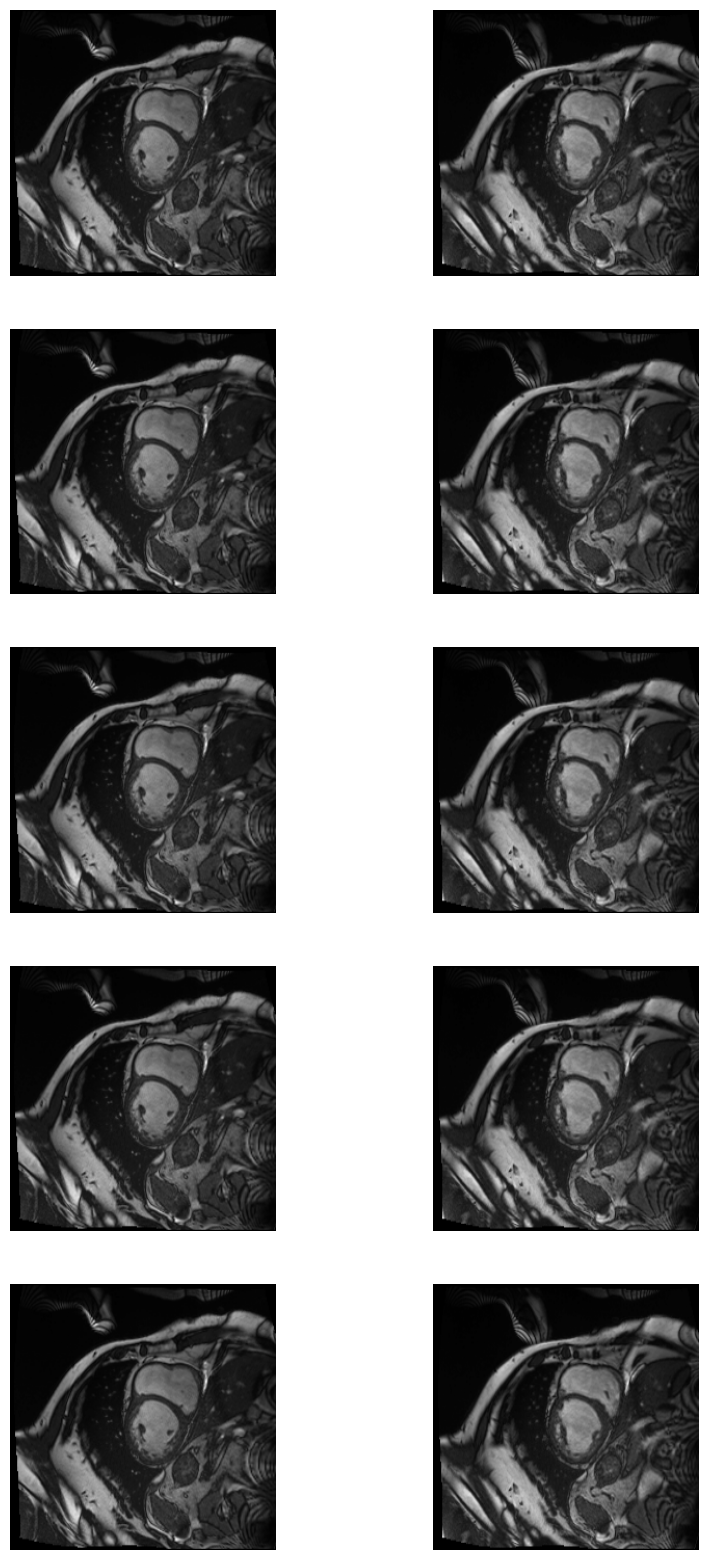

In [20]:
def view_data(image_ds, index):
    plt.figure(figsize=(10,20))
    for i in range(1,6):
        images = image_ds[index]
        view1, view2,_ = images
        plt.subplot(5,2,2*i-1)
        plt.imshow(view1.permute(1,2,0),cmap='gray')
        plt.axis(False)
        plt.subplot(5,2,2*i)
        plt.imshow(view2.permute(1,2,0),cmap='gray')
        plt.axis(False)

view_data(image_ds_train,500)

In [21]:
BATCH_SIZE = config.batch_size # 128 # 16 #128

train_loader = torch.utils.data.DataLoader(
    image_ds_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)

val_loader = torch.utils.data.DataLoader(
    image_ds_val,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)

In [22]:
print("Batches in TRAIN: ", len(train_loader))
print("Batches in VAL: ", len(val_loader))

Batches in TRAIN:  107
Batches in VAL:  39


In [23]:
import torch
import torch.nn as nn
from transformers import Dinov2Model

In [24]:
def save_model(model, save_path):

    # Save the encoder (DINOv2 model)
    model.encoder.save_pretrained(save_path)

    # Save the projection head
    torch.save(model.projection.state_dict(), os.path.join(save_path, 'projection_head.pth'))

def load_model(model_class, load_path, device):
    # Load the encoder (DINOv2 model)
    encoder = Dinov2Model.from_pretrained(load_path)

    # Initialize your custom model
    model = model_class()
    model.encoder = encoder

    # Load the projection head
    projection_head_path = os.path.join(load_path, 'projection_head.pth')
    model.projection.load_state_dict(torch.load(projection_head_path, map_location=device))

    return model


In [25]:
# Plot training function
def plot_training(train_loss_history, save_path, val_loss_history=None):
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history, label='Train Loss')
    if val_loss_history is not None:
        plt.plot(val_loss_history, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(save_path) # config.learning_plot_path
    plt.show()

In [26]:
def contrastive_loss(features, config):
    """Modified NT-Xent loss that handles explicit negative pairs"""
    batch_size = features.shape[0] // 2
    device = features.device
    
    # Create mask for positive pairs (original SimCLR pairs)
    labels = torch.cat([torch.arange(batch_size) for _ in range(2)], dim=0)
    labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float().to(device)
    
    # Calculate similarity matrix
    similarity_matrix = torch.matmul(features, features.T) / config.temperature
    
    # Mask out self-similarity
    mask = torch.eye(labels.shape[0], dtype=torch.bool).to(device)
    labels = labels[~mask].view(labels.shape[0], -1)
    similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1)

    # Select positives and negatives
    positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1)
    negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1)

    logits = torch.cat([positives, negatives], dim=1)
    labels = torch.zeros(logits.shape[0], dtype=torch.long).to(device)

    return logits, labels

In [27]:
class SimCLR(nn.Module):
    def __init__(self, dropout_p=0.5, embedding_size=128, freeze=False):
        super().__init__()
        self.encoder = Dinov2Model.from_pretrained('facebook/dinov2-base')
        if freeze:
            for param in self.encoder.parameters():
                param.requires_grad = False

        self.projection = nn.Sequential(
            nn.Linear(768, 256),
            nn.Dropout(p=dropout_p),
            nn.ReLU(),
            nn.Linear(256, embedding_size)
        )

    def forward(self, x):
        outputs = self.encoder(x)
        encoding = outputs.last_hidden_state[:, 0]  # CLS token
        return self.projection(encoding)

In [28]:
model = SimCLR(dropout_p=config.dropout_p, embedding_size=config.embedding_size).to(config.device)

In [29]:
def contrastive_loss(features, batch_size, temperature=0.1):
    """NT-Xent loss for SimCLR-style samples"""
    device = features.device
    labels = torch.cat([torch.arange(batch_size) for _ in range(2)], dim=0)
    labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float().to(device)
    
    similarity_matrix = torch.matmul(features, features.T) / temperature
    mask = torch.eye(labels.shape[0], dtype=torch.bool).to(device)
    
    labels = labels[~mask].view(labels.shape[0], -1)
    similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1)
    
    positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1)
    negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1)
    
    logits = torch.cat([positives, negatives], dim=1)
    labels = torch.zeros(logits.shape[0], dtype=torch.long).to(device)
    
    return logits, labels

In [30]:
def train(model, train_loader, val_loader, config):
    pair_criterion = nn.BCEWithLogitsLoss()
    contrast_criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
    scheduler = StepLR(optimizer, step_size=config.scheduler_step_size, gamma=config.scheduler_gamma)
    
    best_val_loss = float('inf')
    no_improve = 0
    
    for epoch in range(config.num_epochs):
        model.train()
        epoch_loss = 0.0
        
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            img1, img2, labels = batch
            img1, img2, labels = img1.to(config.device), img2.to(config.device), labels.to(config.device)
            
            optimizer.zero_grad()
            
            # Split batch into pairs and SimCLR samples
            pair_mask = (labels != -1)
            simclr_mask = ~pair_mask
            
            total_loss = 0
            
            # Process explicit pairs
            if torch.any(pair_mask):
                pair_img1 = img1[pair_mask]
                pair_img2 = img2[pair_mask]
                pair_labels = labels[pair_mask]
                
                z1 = model(pair_img1)
                z2 = model(pair_img2)
                similarities = torch.cosine_similarity(z1, z2, dim=-1)
                pair_loss = pair_criterion(similarities, pair_labels)
                total_loss += pair_loss * config.pair_loss_weight
                
            # Process SimCLR samples
            if torch.any(simclr_mask):
                simclr_img1 = img1[simclr_mask]
                simclr_img2 = img2[simclr_mask]
                
                combined = torch.cat([simclr_img1, simclr_img2], dim=0)
                projections = model(combined)
                logits, nt_labels = contrastive_loss(projections, simclr_img1.size(0), config.temperature)
                contrast_loss = contrast_criterion(logits, nt_labels)
                total_loss += contrast_loss * config.contrast_loss_weight
                
            # Backpropagate
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.max_norm)
            optimizer.step()
            epoch_loss += total_loss.item()
        
        # Validation
        val_loss = validate(model, val_loader, config)
        scheduler.step()
        
        # Early stopping and checkpointing
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improve = 0
            torch.save(model.state_dict(), config.best_model_path)
        else:
            no_improve += 1
            if no_improve >= config.patience:
                print("Early stopping")
                break
        
        print(f"Epoch {epoch+1} | Train Loss: {epoch_loss/len(train_loader):.4f} | Val Loss: {val_loss:.4f}")

def validate(model, val_loader, config):
    model.eval()
    total_loss = 0
    pair_criterion = nn.BCEWithLogitsLoss()
    contrast_criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for img1, img2, labels in val_loader:
            img1, img2, labels = img1.to(config.device), img2.to(config.device), labels.to(config.device)
            
            # Split batch
            pair_mask = (labels != -1)
            simclr_mask = ~pair_mask
            
            batch_loss = 0
            
            # Pairs
            if torch.any(pair_mask):
                z1 = model(img1[pair_mask])
                z2 = model(img2[pair_mask])
                similarities = torch.cosine_similarity(z1, z2, dim=-1)
                batch_loss += pair_criterion(similarities, labels[pair_mask]) * config.pair_loss_weight
                
            # SimCLR
            if torch.any(simclr_mask):
                combined = torch.cat([img1[simclr_mask], img2[simclr_mask]], dim=0)
                projections = model(combined)
                logits, nt_labels = contrastive_loss(projections, img1[simclr_mask].size(0), config.temperature)
                batch_loss += contrast_criterion(logits, nt_labels) * config.contrast_loss_weight
                
            total_loss += batch_loss.item()
    
    return total_loss / len(val_loader)


In [31]:
train(model, train_loader, val_loader, config)

Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [03:02<00:00,  1.71s/it]


Epoch 1 | Train Loss: 3.1634 | Val Loss: 3.4791


Epoch 2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [03:00<00:00,  1.69s/it]


Epoch 2 | Train Loss: 3.0741 | Val Loss: 3.4824


Epoch 3: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [02:57<00:00,  1.66s/it]


Epoch 3 | Train Loss: 3.0552 | Val Loss: 3.4854


Epoch 4:  53%|████████████████████████████████████████████████████▋                                              | 57/107 [01:37<01:25,  1.72s/it]


KeyboardInterrupt: 

# Predict

In [28]:
import torch

In [62]:
# ls /home/saahmed/scratch/projects/Image-segmentation/retrieval/checkpoints/simclr_rad-dino_pos-pairs_aug-pairs_epochs100/best_model

In [ ]:
# Load the model with the encoder and projection head
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimCLR(dropout_p=config.dropout_p, embedding_size=config.embedding_size).to(device)
model_path = '/home/saahmed/scratch/projects/Image-segmentation/retrieval/checkpoints/simclr_rad-dino_pos-pairs_aug-pairs_epochs100/best_model'
# Load the encoder and projection head
model = load_model(SimCLR, model_path, device)
model.to(device)
model.eval()


In [30]:
from PIL import Image

def get_embedding(model, image, transform, device):
    # Transform the image
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension
    with torch.no_grad():
        # Get the projection as the image embedding
        embedding = model([image])
    return embedding.cpu().numpy().squeeze()


In [31]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def retrieve_similar_images(query_embedding, database_embeddings, top_k=5):
    # Compute cosine similarity between query and database embeddings
    similarities = cosine_similarity([query_embedding], database_embeddings)
    # Get indices of the top-k most similar images
    top_k_indices = np.argsort(similarities[0])[-top_k:][::-1]
    return top_k_indices, similarities[0][top_k_indices]


In [69]:
ls /home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/ed

ed/  es/


In [32]:
ed_train = ['/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/ed/images/'+i for i in os.listdir('/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/ed/images/')]
es_train = ['/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/es/images/'+i for i in os.listdir('/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/es/images/')]
images = ed_train + es_train

In [33]:
ed_test = ['/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/ed/images/'+i for i in os.listdir('/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/ed/images/')]
es_test = ['/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/es/images/'+i for i in os.listdir('/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/es/images/')]
images_test = ed_test+ es_test

In [75]:
import matplotlib.pyplot as plt

def show_query_and_results(query_image_path, database_images, top_k_indices,save_path=None,show=None):
    # Display the query image
    plt.figure(figsize=(20, 5))
    plt.subplot(1, top_k_indices.size + 1, 1)
    plt.imshow(Image.open(query_image_path),cmap='gray')
    plt.axis("off")
    plt.title("Query Image")

    # Display top-K most similar images
    for i, idx in enumerate(top_k_indices):
        plt.subplot(1, top_k_indices.size + 1, i + 2)
        img = Image.open(database_images[idx])
        plt.imshow(img,cmap='gray')
        plt.axis("off")
        plt.title(f"Similar Image {i + 1}")
        
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')  # Save with tight bounding box

        
    if show:
        plt.show()
    else:
        plt.close()
    

In [35]:
database_images = images
database_embeddings = []

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Lambda(convert_to_rgb),
    transforms.ToTensor(),
])

# Extract embeddings for all database images
for img_path in tqdm(database_images):
    img = Image.open(img_path)
    embedding = get_embedding(model, img, transform, device)
    database_embeddings.append(embedding)

# Convert to NumPy array for similarity search
database_embeddings = np.array(database_embeddings)


100%|███████████████████████████████████████| 1902/1902 [00:32<00:00, 57.89it/s]


In [36]:
database_images_Test = images_test
database_embeddings_test = []

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Lambda(convert_to_rgb),
    transforms.ToTensor(),
])

# Extract embeddings for all database images
for img_path in tqdm(database_images_Test):
    img = Image.open(img_path)
    embedding = get_embedding(model, img, transform, device)
    database_embeddings_test.append(embedding)

# Convert to NumPy array for similarity search
database_embeddings_test = np.array(database_embeddings_test)


100%|███████████████████████████████████████| 1076/1076 [00:18<00:00, 58.60it/s]


Query Image:  /home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/ed/images/patient027_frame01_slice_8.png
Most similar images:
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/ed/images/patient093_frame01_slice_8.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/es/images/patient027_frame11_slice_8.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/es/images/patient093_frame14_slice_8.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/ed/images/patient027_frame01_slice_9.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/ed/images/patient027_frame01_slice_7.png
Similarity scores: [0.99291766 0.9915403  0.96896005 0.8989583  0.8976807 ]


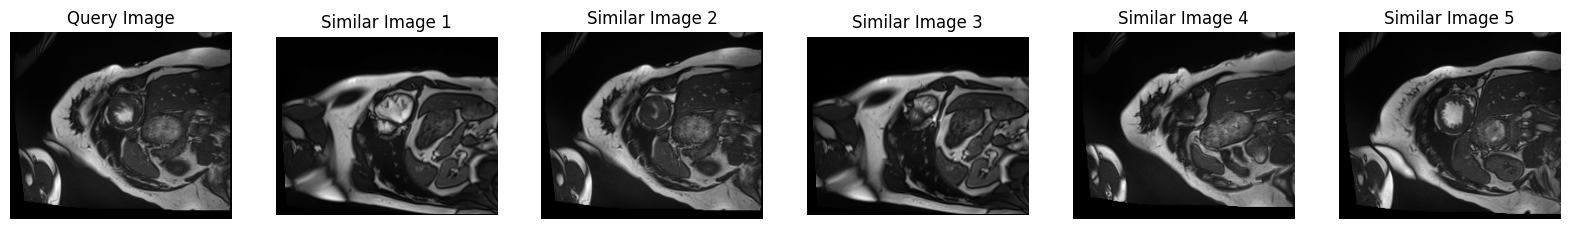

In [39]:
# Query Image
query_image_path = "/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/ed/images/patient027_frame01_slice_8.png"  
query_image = Image.open(query_image_path)
query_embedding = get_embedding(model, query_image, transform, device)


# Retrieve most similar images
top_k_indices, similarities = retrieve_similar_images(query_embedding, database_embeddings, top_k=6)
print("Query Image: ",query_image_path)
print("Most similar images:")
for idx in top_k_indices[1:]:
    print(database_images[idx])
# [database_images[idx] for idx in top_k_indices]
print("Similarity scores:", similarities[1:])


# Show query and top similar images
show_query_and_results(query_image_path, database_images, top_k_indices[1:])


Query Image:  /home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/ed/images/patient099_frame01_slice_1.png
Most similar images:
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/ed/images/patient099_frame01_slice_0.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/es/images/patient099_frame09_slice_1.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/ed/images/patient099_frame01_slice_2.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/es/images/patient099_frame09_slice_0.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/es/images/patient099_frame09_slice_2.png
Similarity scores: [0.9937554  0.9830689  0.9726658  0.96841544 0.95731217]


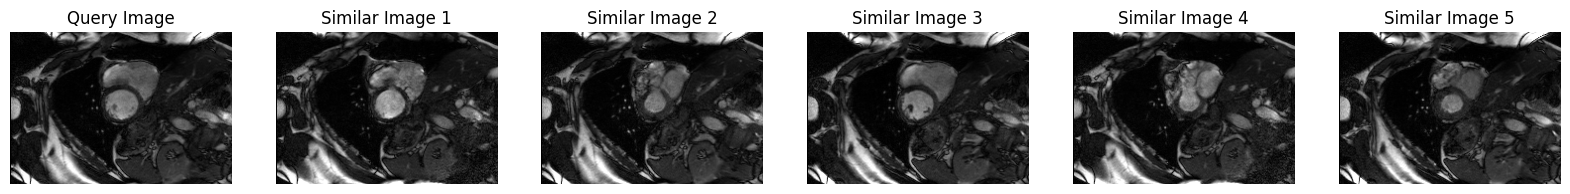

In [40]:
# Query Image
query_image_path = "/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/ed/images/patient099_frame01_slice_1.png"
query_image = Image.open(query_image_path)
query_embedding = get_embedding(model, query_image, transform, device)

# Retrieve most similar images
top_k_indices, similarities = retrieve_similar_images(query_embedding, database_embeddings, top_k=6)
print("Query Image: ",query_image_path)
print("Most similar images:")
for idx in top_k_indices[1:]:
    print(database_images[idx])
# [database_images[idx] for idx in top_k_indices]
print("Similarity scores:", similarities[1:])


# Show query and top similar images
show_query_and_results(query_image_path, database_images, top_k_indices[1:])


Query Image:  /home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/ed/images/patient061_frame01_slice_5.png
Most similar images:
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/es/images/patient061_frame10_slice_5.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/es/images/patient014_frame13_slice_5.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/ed/images/patient061_frame01_slice_4.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/es/images/patient061_frame10_slice_4.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/ed/images/patient031_frame01_slice_4.png
Similarity scores: [0.94354844 0.9210775  0.90633976 0.8885471  0.8826428 ]


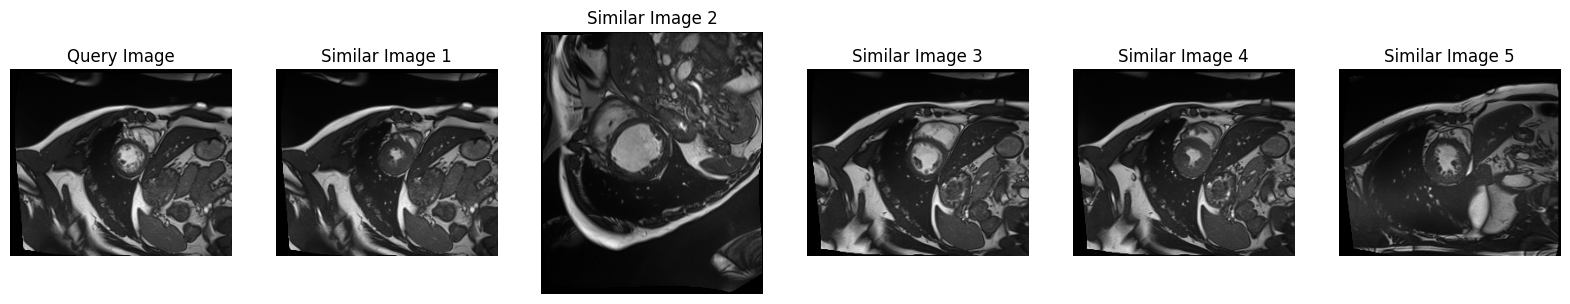

In [41]:
# Query Image
query_image_path = "/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/ed/images/patient061_frame01_slice_5.png"
query_image = Image.open(query_image_path)
query_embedding = get_embedding(model, query_image, transform, device)

# Retrieve most similar images
top_k_indices, similarities = retrieve_similar_images(query_embedding, database_embeddings, top_k=6)
print("Query Image: ",query_image_path)
print("Most similar images:")
for idx in top_k_indices[1:]:
    print(database_images[idx])
# [database_images[idx] for idx in top_k_indices]
print("Similarity scores:", similarities[1:])


# Show query and top similar images
show_query_and_results(query_image_path, database_images, top_k_indices[1:])


In [69]:
images_test[:10]

['output_data/Testing/ed/images/patient120_frame01_slice_2.png',
 'output_data/Testing/ed/images/patient134_frame01_slice_6.png',
 'output_data/Testing/ed/images/patient139_frame01_slice_1.png',
 'output_data/Testing/ed/images/patient116_frame01_slice_7.png',
 'output_data/Testing/ed/images/patient140_frame01_slice_16.png',
 'output_data/Testing/ed/images/patient122_frame01_slice_5.png',
 'output_data/Testing/ed/images/patient132_frame01_slice_2.png',
 'output_data/Testing/ed/images/patient133_frame01_slice_7.png',
 'output_data/Testing/ed/images/patient132_frame01_slice_9.png',
 'output_data/Testing/ed/images/patient108_frame01_slice_6.png']

Query Image:  /home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/ed/images/patient121_frame01_slice_3.png
Most similar images:
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/ed/images/patient121_frame01_slice_2.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/ed/images/patient121_frame01_slice_4.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/ed/images/patient121_frame01_slice_1.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/es/images/patient121_frame10_slice_3.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/es/images/patient121_frame10_slice_2.png
Similarity scores: [0.9680189  0.96467584 0.9628035  0.9078002  0.89057577]


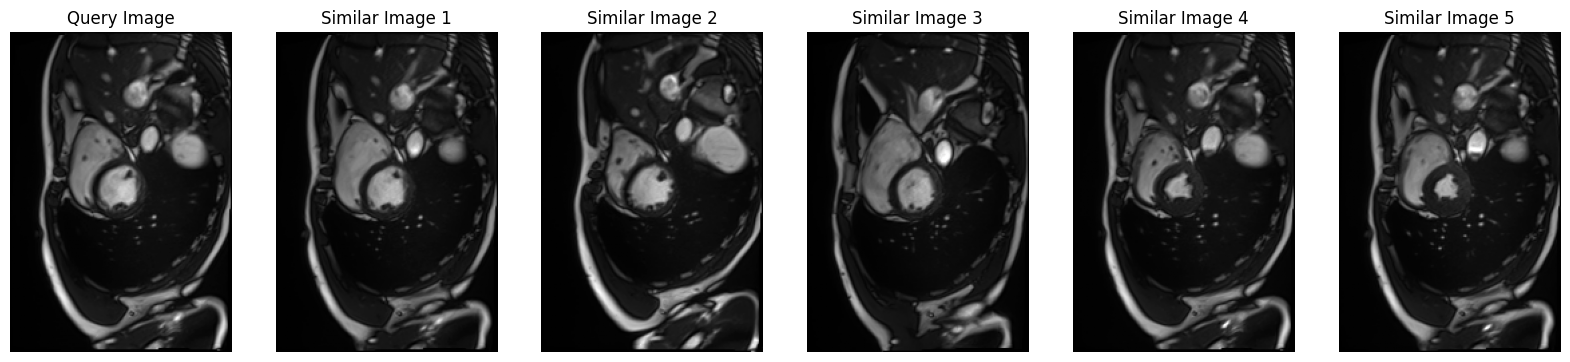

In [79]:
# Query Image
query_image_path = images_test[0]
query_image = Image.open(query_image_path)
query_embedding = get_embedding(model, query_image, transform, device)

# Retrieve most similar images
top_k_indices, similarities = retrieve_similar_images(query_embedding, database_embeddings_test,top_k=6)
print('Query Image: ',query_image_path)
print("Most similar images:")
for idx in top_k_indices[1:]:
    print(database_images_Test[idx])
# [database_images[idx] for idx in top_k_indices]
print("Similarity scores:", similarities[1:])


# Show query and top similar images
show_query_and_results(query_image_path, database_images_Test, top_k_indices[1:],save_path=query_image_path.split("/")[-1],show=True)

Query Image:  /home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/ed/images/patient115_frame01_slice_7.png
Most similar images:
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/es/images/patient115_frame13_slice_7.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/ed/images/patient115_frame01_slice_5.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/ed/images/patient115_frame01_slice_2.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/es/images/patient115_frame13_slice_5.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/es/images/patient115_frame13_slice_8.png
Similarity scores: [0.9991859  0.980009   0.97352725 0.9715891  0.957913  ]


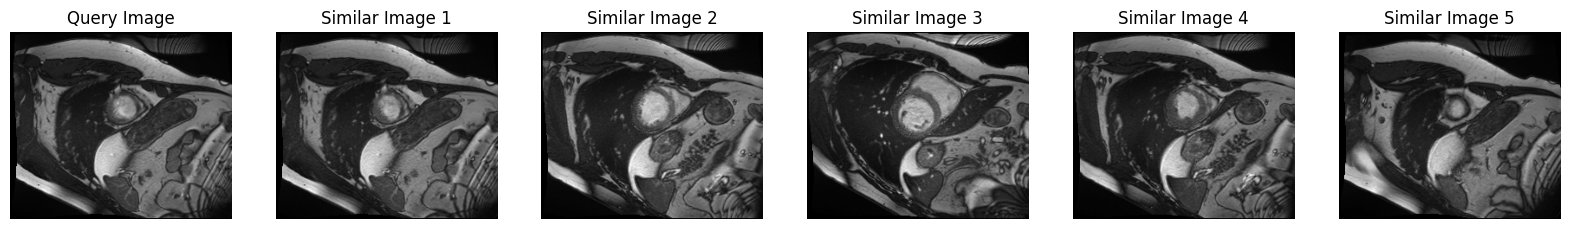

In [80]:
# Query Image
query_image_path = images_test[2]
query_image = Image.open(query_image_path)
query_embedding = get_embedding(model, query_image, transform, device)


top_k_indices, similarities = retrieve_similar_images(query_embedding, database_embeddings_test,top_k=6)
print('Query Image: ',query_image_path)
print("Most similar images:")
for idx in top_k_indices[1:]:
    print(database_images_Test[idx])
# [database_images[idx] for idx in top_k_indices]
print("Similarity scores:", similarities[1:])


# Show query and top similar images
show_query_and_results(query_image_path, database_images_Test, top_k_indices[1:],save_path=query_image_path.split("/")[-1],show=True)


Query Image:  /home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/ed/images/patient110_frame01_slice_0.png
Most similar images:
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/es/images/patient110_frame11_slice_0.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/ed/images/patient110_frame01_slice_2.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/ed/images/patient110_frame01_slice_1.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/es/images/patient110_frame11_slice_3.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/es/images/patient110_frame11_slice_2.png
Similarity scores: [0.9930255  0.88022244 0.8601348  0.8593522  0.851839  ]


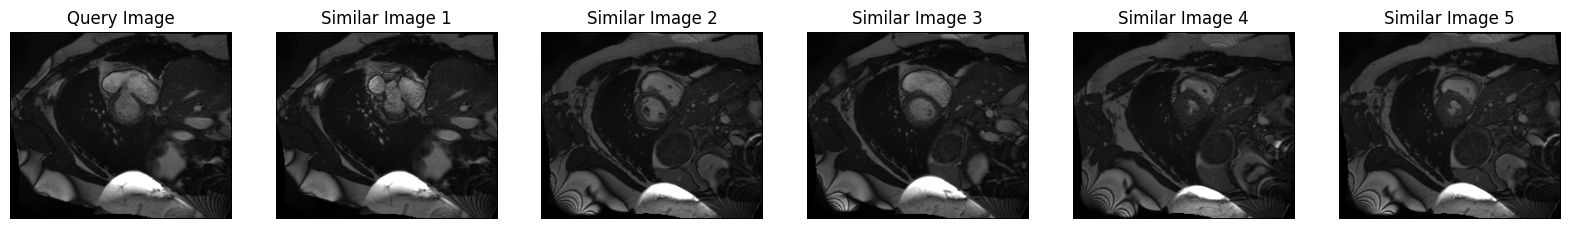

In [81]:
# Query Image
query_image_path = images_test[6]
query_image = Image.open(query_image_path)
query_embedding = get_embedding(model, query_image, transform, device)

top_k_indices, similarities = retrieve_similar_images(query_embedding, database_embeddings_test,top_k=6)
print('Query Image: ',query_image_path)
print("Most similar images:")
for idx in top_k_indices[1:]:
    print(database_images_Test[idx])
# [database_images[idx] for idx in top_k_indices]
print("Similarity scores:", similarities[1:])


# Show query and top similar images
show_query_and_results(query_image_path, database_images_Test, top_k_indices[1:],save_path=query_image_path.split("/")[-1],show=True)


Query Image:  /home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/ed/images/patient141_frame01_slice_5.png
Most similar images:
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/ed/images/patient141_frame01_slice_4.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/ed/images/patient141_frame01_slice_6.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/ed/images/patient141_frame01_slice_3.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/es/images/patient140_frame09_slice_15.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/es/images/patient141_frame11_slice_7.png
Similarity scores: [0.9871036  0.98080724 0.95826024 0.9439829  0.93603814]


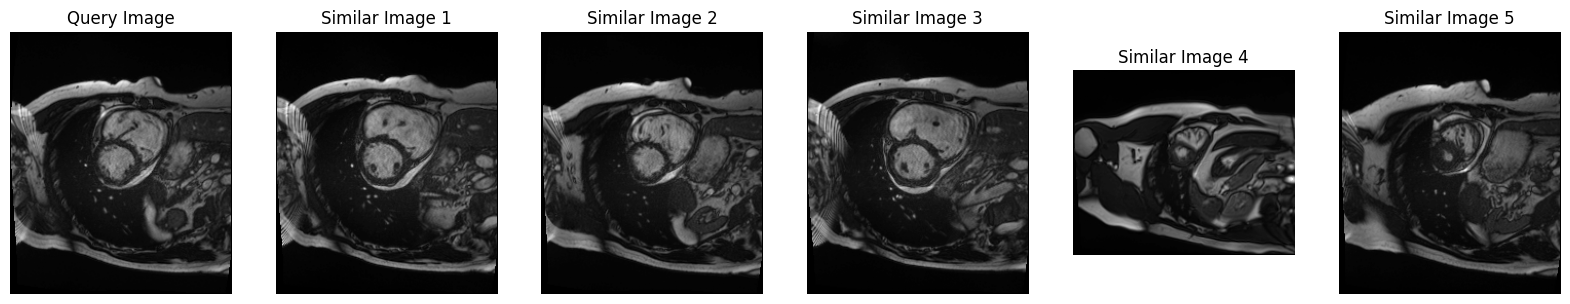

In [90]:
# Query Image
query_image_path = images_test[30]
query_image = Image.open(query_image_path)
query_embedding = get_embedding(model, query_image, transform, device)

top_k_indices, similarities = retrieve_similar_images(query_embedding, database_embeddings_test,top_k=6)
print('Query Image: ',query_image_path)
print("Most similar images:")
for idx in top_k_indices[1:]:
    print(database_images_Test[idx])
# [database_images[idx] for idx in top_k_indices]
print("Similarity scores:", similarities[1:])


# Show query and top similar images
show_query_and_results(query_image_path, database_images_Test, top_k_indices[1:],save_path=query_image_path.split("/")[-1],show=True)


In [72]:
# mkdir Test_results

In [77]:
# for i in tqdm(range(len(images_test))):
#     # Query Image
#     query_image_path = images_test[i]
#     query_image = Image.open(query_image_path)
#     query_embedding = get_embedding(model, query_image, transform, device)
    
#     top_k_indices, similarities = retrieve_similar_images(query_embedding, database_embeddings_test,top_k=6)

#     show_query_and_results(query_image_path, database_images_Test, top_k_indices[1:],save_path='Test_results/'+query_image_path.split("/")[-1])
    
